Server side code:

Hub was disconnected.


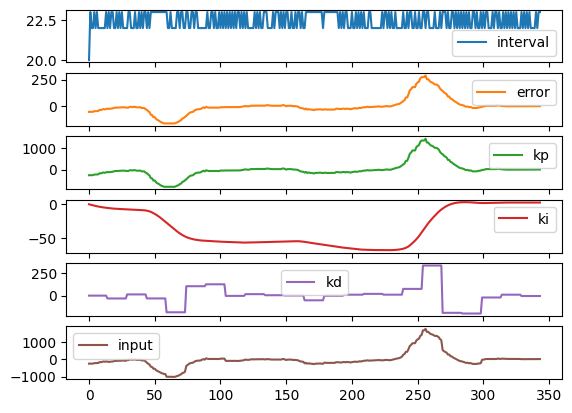

In [40]:
import asyncio
import pandas as pd
from time import time
from bleak import BleakScanner, BleakClient

UART_SERVICE_UUID = "6E400001-B5A3-F393-E0A9-E50E24DCCA9E"
UART_RX_CHAR_UUID = "6E400002-B5A3-F393-E0A9-E50E24DCCA9E"
UART_TX_CHAR_UUID = "6E400003-B5A3-F393-E0A9-E50E24DCCA9E"

HUB_NAME = "Robot Hub"

def hub_filter(device, ad):
    return device.name and device.name.lower() == HUB_NAME.lower()

def handle_disconnect(_):
    print("Hub was disconnected.")

last_update = time()

concatenated = ""
table = pd.DataFrame(columns=["interval", "error", "kp", "ki", "kd", "input"])

def handle_rx(_, data: bytearray):
    global last_update
    global concatenated
    global table

    last_update = time()

    decoded = data.decode()
    concatenated += decoded
    
    split = concatenated.split("#", 1)

    if(len(split) == 2):
        interval, error, kp, ki, kd, input = map(lambda entry : float(entry), split[0].split(";"))
        table.loc[len(table.index)] = [interval, error, kp, ki, kd, input]

        concatenated = split[1]

device = await BleakScanner.find_device_by_filter(hub_filter)
client = BleakClient(device, disconnected_callback=handle_disconnect)

async def send(client, data):
    await client.write_gatt_char(rx_char, data)

try:
    await client.connect()
    await client.start_notify(UART_TX_CHAR_UUID, handle_rx)
    nus = client.services.get_service(UART_SERVICE_UUID)
    rx_char = nus.get_characteristic(UART_RX_CHAR_UUID)

    await send(client, b"5.000")
    await send(client, b"0.010")
    await send(client, b"500.0")

    while(time() - last_update < 2):
        await asyncio.sleep(1)

except Exception as e:
    print(e)
finally:
    await client.disconnect()

if(len(table.index) > 0):
    table.plot(subplots=True)


Hub side code:

```Python
from pybricks.hubs import InventorHub
from pybricks.pupdevices import Motor, UltrasonicSensor
from pybricks.parameters import Button, Color, Direction, Port, Side, Stop
from pybricks.robotics import DriveBase
from pybricks.tools import wait, StopWatch

from usys import stdin, stdout

hub = InventorHub()
hub.light.on(Color.GREEN)

# left side
motor_right_back = Motor(Port.C)
motor_right_front = Motor(Port.E)

# right side
motor_left_back = Motor(Port.B, Direction.COUNTERCLOCKWISE)
motor_left_front = Motor(Port.D, Direction.COUNTERCLOCKWISE)

distance = UltrasonicSensor(Port.F)

motors = [
    motor_right_back,
    motor_right_front,
    motor_left_back,
    motor_left_front
]

hub.display.animate([
    [
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [80, 0, 20, 0, 20]
    ],
    [
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [20, 0, 80, 0, 20]
    ],
    [
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [20, 0, 20, 0, 80]
    ]
], 500)

kp = float(stdin.buffer.read(5))
ki = float(stdin.buffer.read(5))
kd = float(stdin.buffer.read(5))

hub.display.icon([
    [0, 0, 0, 0, 0],
    [0, 0, 0, 0, 50],
    [0, 0, 0, 50, 0],
    [50, 0, 50, 0, 0],
    [0, 50, 0, 0, 0]
])

distance_setpoint = 200

stopWatch = StopWatch()

# generic insights
last_time = stopWatch.time()

# ki
i_accumulated_error = 0

# kd
d_last_time = stopWatch.time()
d_difference_time = 0

d_last_error = 0

d_reading_count = 0
derivative_input = 0

while(True):
    wait(20)

    time = stopWatch.time()
    difference_time = time - last_time

    error = distance.distance() - distance_setpoint

    proportial_input = error * kp

    i_accumulated_error += error
    integral_input = i_accumulated_error * ki

    d_reading_count += 1
    if(d_reading_count % 15 == 0):
        d_time = stopWatch.time()
        d_difference_error = error - d_last_error
        d_difference_time = time - d_last_time

        derivative_input = (d_difference_error / d_difference_time) * kd

        d_last_error = error
        d_last_time = d_time

    combined_input = proportial_input + integral_input + derivative_input

    stdout.buffer.write(
        str(difference_time)
        + ";" + str(error)
        + ";" + str(proportial_input)
        + ";" + str(integral_input)
        + ";" + str(derivative_input)
        + ";" + str(combined_input)
        + "#")

    for motor in motors:
        motor.run(combined_input)

    last_time = time
```